# Use some points to predict others

### Team: MapReduce, MapReuse, MapRecycle
Members: Tennison Yu, Madeleine Bulkow, Mark Paluta, Alex Dauenhauer

https://github.com/tyu0912/207_facial_recognition/tree/master
https://github.com/tyu0912/MIDS_W207_facial_recognition/issues

## Data 

### Loading datasets and packages

keep import cell
- plan is to split train and dev data and use `validation_data` in fit

In [1]:
# Optional cell to install/update all required packages
! pip install keras tensorflow numpy pandas matplotlib scipy imgaug opencv-python > nul
print('Packages installed, output supressed for cleanliness')

Packages installed, output supressed for cleanliness


In [2]:
import time, os, keras, tensorflow as tf, decimal, warnings, imgaug as ia
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import backend as K
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy import stats
from imgaug import augmenters as iaa

# set tensorflow as keras backend
if K.backend() != "tensorflow":
    os.environ['KERAS_BACKEND'] = "tensorflow"
    reload(K)

print('keras version:', keras.__version__)
print('tensorflow version:', tf.__version__)
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)

# Initiate settings and load the data.
np.random.seed(0)
pd.options.display.max_columns = 30
warnings.filterwarnings('ignore')

train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
features = train.columns[:-1]

Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0
pandas version: 0.23.4
numpy version: 1.15.4


### Glancing at the Data

In [3]:
print('Sample Training Labels')
train[train.columns[:-1]].head(5)

Sample Training Labels


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [4]:
print('Sample Image Pixels')
train['Image'].head(5)

Sample Image Pixels


0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

### Splitting the Data

- for keras model we need numpy array of shape = (X, 96, 96, 1)
- test how the model works with NAs included and with them removed --> custom loss function Maddie
- We will split train and test data in the loading function and use `validation_data` arg in keras

In [5]:
def process_datasets(df, test=False):
    # Missing Data Handling:
    #df = df.fillna(0)
    #df = df.dropna()
    
    facial_point_labels = df.iloc[:, :-1]
    images_pixel_feature = df.Image.apply(lambda im: np.fromstring(im, sep=' '))
    
    # separate data and reshape the images
    images_pixel_feature = np.stack(images_pixel_feature) / 255
    images_pixel_feature = images_pixel_feature.reshape(-1, 96, 96, 1)
    
    # separate the labels and scale them to [-1,1] interval
    if not test:
        facial_point_labels = facial_point_labels.values
        facial_point_labels = (facial_point_labels - 48) / 48
    
    return images_pixel_feature, facial_point_labels

train_all_features, train_all_labels = process_datasets(train)

In [6]:
# 20% of the data will go to dev
percent_to_dev = 0.2 

train_data, dev_data, train_labels, dev_labels = train_test_split(train_all_features, train_all_labels, test_size=percent_to_dev)
test_data, test_labels = process_datasets(test)

print("\nTrain data shape", train_data.shape)
print("Dev data shape", dev_data.shape)
print("Train labels shape", train_labels.shape)
print("Dev labels shape", dev_labels.shape)

print("\nData Generation Finished")


Train data shape (5639, 96, 96, 1)
Dev data shape (1410, 96, 96, 1)
Train labels shape (5639, 30)
Dev labels shape (1410, 30)

Data Generation Finished


### Checking Images and Features

In [22]:
def plot_sample(data, labels, labels2 = []):
    '''
    data must be a numpy.ndarray of shape (X, 96, 96, 1)
    labels must be a numpy.ndarray (X, 30)
    the indices must line up between the two
    
    need to update to handle any square number of images
    '''
    
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(labels.shape[0]):
        img = data[i].reshape(96,96)
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(data[i].reshape(96,96), cmap='gray')
        ax.scatter(labels[i][0::2] * 48 + 48, labels[i][1::2] * 48 + 48, c='r')
        if(len(labels2)!= 0):
            ax.scatter(labels2[i][0::2] * 48 + 48, labels2[i][1::2] * 48 + 48, c='b')

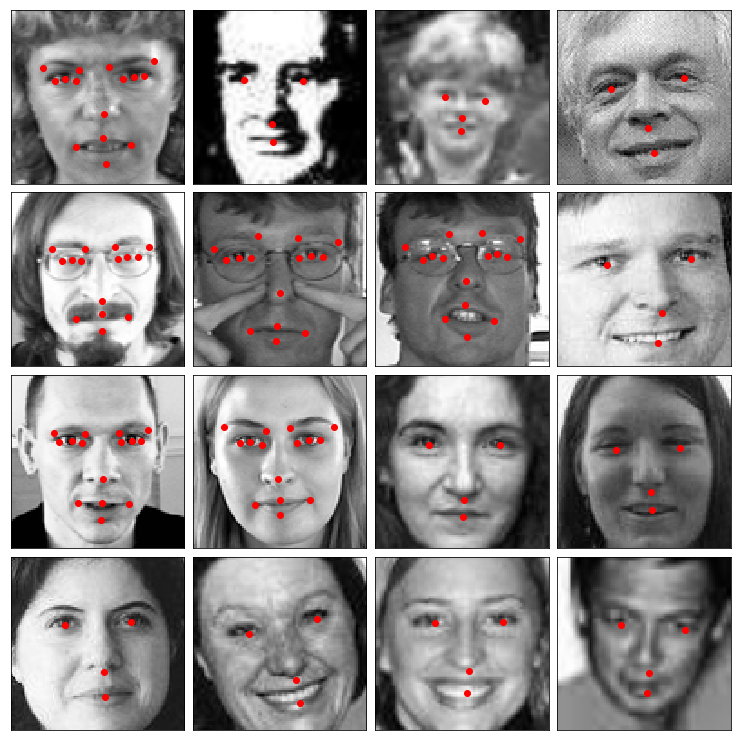

In [23]:
# Output 16 random images. Some of these will be the NA data

idx = np.random.randint(0, len(train_data), 16)
data_sample = train_data[idx, :, :, :]
label_sample = train_labels[idx, :]

plot_sample(data_sample, label_sample)

In [9]:
# move this cell closer to the top, but putting it here now for convenience in referencing for cell below.
i = 0
feature_dict = {}
for label in train.columns.values:
    feature_dict[label] = i
    i += 1
print(feature_dict)

{'left_eye_center_x': 0, 'left_eye_center_y': 1, 'right_eye_center_x': 2, 'right_eye_center_y': 3, 'left_eye_inner_corner_x': 4, 'left_eye_inner_corner_y': 5, 'left_eye_outer_corner_x': 6, 'left_eye_outer_corner_y': 7, 'right_eye_inner_corner_x': 8, 'right_eye_inner_corner_y': 9, 'right_eye_outer_corner_x': 10, 'right_eye_outer_corner_y': 11, 'left_eyebrow_inner_end_x': 12, 'left_eyebrow_inner_end_y': 13, 'left_eyebrow_outer_end_x': 14, 'left_eyebrow_outer_end_y': 15, 'right_eyebrow_inner_end_x': 16, 'right_eyebrow_inner_end_y': 17, 'right_eyebrow_outer_end_x': 18, 'right_eyebrow_outer_end_y': 19, 'nose_tip_x': 20, 'nose_tip_y': 21, 'mouth_left_corner_x': 22, 'mouth_left_corner_y': 23, 'mouth_right_corner_x': 24, 'mouth_right_corner_y': 25, 'mouth_center_top_lip_x': 26, 'mouth_center_top_lip_y': 27, 'mouth_center_bottom_lip_x': 28, 'mouth_center_bottom_lip_y': 29, 'Image': 30}


In [10]:
i = 0
for label in train.columns[:-1].values:
    print(i, ' ', label, ' ', np.sum(np.logical_not(np.isnan(train_labels[:,i]))))
    i += 1

0   left_eye_center_x   5631
1   left_eye_center_y   5631
2   right_eye_center_x   5629
3   right_eye_center_y   5629
4   left_eye_inner_corner_x   1826
5   left_eye_inner_corner_y   1826
6   left_eye_outer_corner_x   1822
7   left_eye_outer_corner_y   1822
8   right_eye_inner_corner_x   1823
9   right_eye_inner_corner_y   1823
10   right_eye_outer_corner_x   1821
11   right_eye_outer_corner_y   1821
12   left_eyebrow_inner_end_x   1823
13   left_eyebrow_inner_end_y   1823
14   left_eyebrow_outer_end_x   1786
15   left_eyebrow_outer_end_y   1786
16   right_eyebrow_inner_end_x   1824
17   right_eyebrow_inner_end_y   1824
18   right_eyebrow_outer_end_x   1796
19   right_eyebrow_outer_end_y   1796
20   nose_tip_x   5639
21   nose_tip_y   5639
22   mouth_left_corner_x   1823
23   mouth_left_corner_y   1823
24   mouth_right_corner_x   1821
25   mouth_right_corner_y   1821
26   mouth_center_top_lip_x   1827
27   mouth_center_top_lip_y   1827
28   mouth_center_bottom_lip_x   5609
29   mouth_c

In [25]:
is_data_complete = np.logical_not(np.any(np.isnan(train_labels),axis = 1))
train_data_complete = train_data[is_data_complete]
train_labels_complete = train_labels[is_data_complete]
len(train_data_complete)

1716

In [12]:
def mean_squared_error_with_missing(y_true, y_pred):
    
    # figure out which labels are present
    present = tf.logical_not(tf.is_nan(y_true))
    
    # select only those labels
    present_labels_true = tf.boolean_mask(y_true, present)
    present_labels_pred = tf.boolean_mask(y_pred, present)
    
    
    # compute mean squared error
    loss = tf.math.reduce_mean(tf.math.squared_difference(present_labels_true,present_labels_pred))
    
    return loss

In [13]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [16]:
model = Sequential()
model.add(Dense(units=1000,activation='relu'))
model.add(Dense(units=1000,activation='relu'))
model.add(Dense(units=1000,activation='relu'))

# create the output layer
model.add(Dense(units=30))

# compile the model
#model.compile(loss='mean_squared_error', optimizer=optimizer)
model.compile(loss=mean_squared_error_with_missing, optimizer='Adam')


time_callback = TimeHistory()
hist = model.fit(
    train_labels_complete[:,[0,1,2,3,20,21,28,29]], train_labels_complete, 
    batch_size=32,
    epochs=10, 
    validation_split=0.2, 
#     validation_data = dev_data
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 1372 samples, validate on 344 samples
Epoch 1/10
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0149 - val_loss: 0.0037
Epoch 2/10
1372/1372 [==============================] - 2s 2ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 3/10
1372/1372 [==============================] - 2s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/10
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/10
1372/1372 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/10
1372/1372 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/10
1372/1372 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/10
1372/1372 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/10
1372/1372 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/10
1372/1372 [============

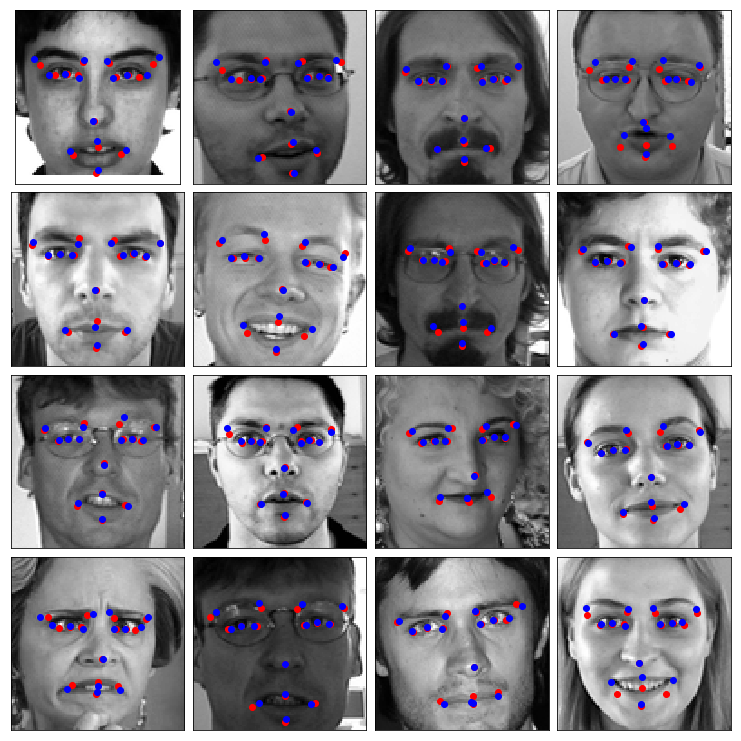

In [24]:
# Output 16 random images. Some of these will be the NA data

idx = np.random.randint(0, len(train_data_complete), 16)
data_sample = train_data_complete[idx, :, :, :]

pred = model.predict(train_labels_complete[:,[0,1,2,3,20,21,28,29]])

label_sample = pred[idx, :]
label_sample_true = train_labels_complete[idx, :]

plot_sample(data_sample, label_sample, labels2 = label_sample_true)